Changes made:
1. semilogy on the y axis to plot on a logarithmic scale
2. I am not converting y axis values to 10log10, a mistake i made earlier
3. Removed digitization step for coeff = digitize(coeff)


In [3]:
import numpy as np
from scipy import special
from numpy.linalg import lstsq
import matplotlib.pyplot as plt
import math

In [5]:
# Jakes filter implementation
def Jakes_filter(f_max, Ts, N):
    L = N // 2
    n = np.arange(1, L + 1)
    J_pos = special.jv(0.25, 2 * np.pi * f_max * n * Ts) / (n ** 0.25)
    J_neg = np.flip(J_pos)
    J_0 = 1.468813 * (f_max * Ts) ** 0.25
    J = np.concatenate((J_neg, [J_0], J_pos))
    n = np.arange(0, N + 1)
    hamm = 0.54 - 0.46 * np.cos(2 * np.pi * n / N)
    hw = J * hamm
    hw = hw / np.sqrt(np.sum(np.abs(hw) ** 2))
    return hw

# Generate Rayleigh envelope using Jakes model
def generate_rayleigh_envelope(signal_length, velocity, carrier_frequency):
    c = 3e8  # Speed of light in m/s
    fd = velocity * carrier_frequency / c
    Fs = 100000 # Sampling frequency
    N = 512
    Ts = 1 / Fs
    h = Jakes_filter(fd, Ts, N)
    x = np.random.randn(signal_length + 1000)
    y = np.convolve(x, h)
    return np.array(y[500:500 + signal_length])

In [7]:
# Function to digitize the signal
def digitize(signal):
    return np.where(signal >= 0, 1, -1)


In [9]:
# BPSK signal generation
def generate_bpsk_signal(N):
    bits = np.random.randint(0, 2, N)
    bpsk_signal = 2 * bits - 1
    return bpsk_signal

In [29]:
# Parameters
Fs = 10000   # Sampling frequency
Fc = 1e9     # Carrier frequency
Fd = 100     # Doppler frequency
velocity = 30  # Velocity of the receiver
Tc = 1 / (10 * Fd)  # Coherence time (based on Doppler frequency)
N = 1000000    # Number of data points in the signal
M = 3        # Number of different channel values (multi-path)
packet_size = math.floor(Fs * Tc)  # Size of each packet
header_packet_size = math.floor((1 / 6) * packet_size)  # Known part of the signal

In [31]:
# Generate BPSK modulated signal
signal = generate_bpsk_signal(N)

# Generate Rayleigh fading channel values
channel_values = np.array([generate_rayleigh_envelope(N, velocity, Fc) for _ in range(M)])

# Range of SNR values in dB
snr_db_range = np.arange(-5, 15, 2)  # SNR from -5 dB to 20 dB
ber_values = []
mse_values = []

In [32]:
# Loop over each SNR value
for snr_db in snr_db_range:
    snr_linear = 10 ** (snr_db / 10)  # Convert dB to linear scale
    noise_level = 1 / snr_linear      # Noise level (1/SNR, dB value = 10*log10(SNR))

    header_error = np.zeros(M)
    header_wrong_count = np.zeros(M)
    num = np.zeros(M)
    header_bit_count = np.zeros(M)
    cleaned_results = np.zeros((M, N))

    # Generate Rayleigh fading channel values
    channel_values = np.array([generate_rayleigh_envelope(N, velocity, Fc) for _ in range(M)])

    # Loop over each packet
    for packet_start in range(0, len(signal), packet_size):
        packet_end = min(packet_start + packet_size, len(signal))
        current_signal = signal[packet_start:packet_end]
        current_channel_values = channel_values[:, packet_start:packet_end]

        for i in range(M):
            scaled = current_signal * current_channel_values[i]
            average_signal_power = np.mean(scaled ** 2)
            var_noise = average_signal_power * noise_level
            noise = np.random.normal(0, np.sqrt(var_noise), current_signal.shape)
            noisy = scaled + noise
            noisy_dig = digitize(noisy)

            # Perform LS separation
            header_start = int(packet_size / 2 - header_packet_size / 2)
            header_end = header_start + header_packet_size
            coeff, residuals, rank, s = lstsq(
                current_signal[header_start:header_end].reshape(-1, 1),
                noisy_dig[header_start:header_end]
            )
            cleaned_temp = noisy_dig / coeff
            cleaned = digitize(cleaned_temp)

            # Calculate header MSE
            header_error[i] += np.sum((coeff - current_channel_values[i]) ** 2)
            header_wrong_count[i] += np.sum(
                current_signal[header_start:header_end] != 
                cleaned[header_start:header_end]
            )
            num[i] += len(current_signal[header_start:header_end])
            header_bit_count[i] += len(current_channel_values[i])

            cleaned_results[i][packet_start:packet_end] = cleaned

    # Calculate BER and MSE
    ber = np.mean([np.sum(np.abs(signal - cleaned_results[i])) for i in range(M)]) / N
    mse = np.mean(header_error / header_bit_count)
    ber_values.append(ber)
    mse_values.append(mse)


C:\Users\vigne\AppData\Local\Temp\ipykernel_11476\2016796726.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeff, residuals, rank, s = lstsq(


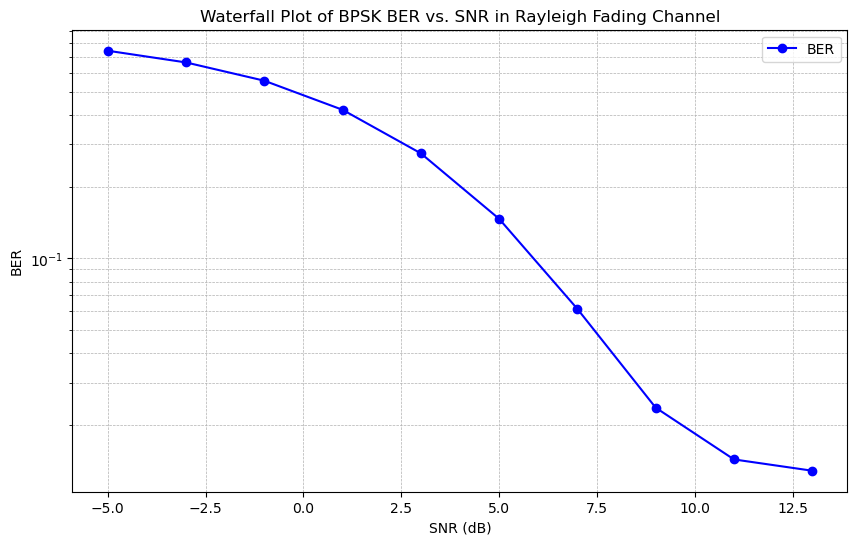

In [34]:
# Plot BER vs. SNR
plt.figure(figsize=(10, 6))
plt.semilogy(snr_db_range, ber_values, marker='o', linestyle='-', color='b', label='BER')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('Waterfall Plot of BPSK BER vs. SNR in Rayleigh Fading Channel')
plt.legend()
plt.show()

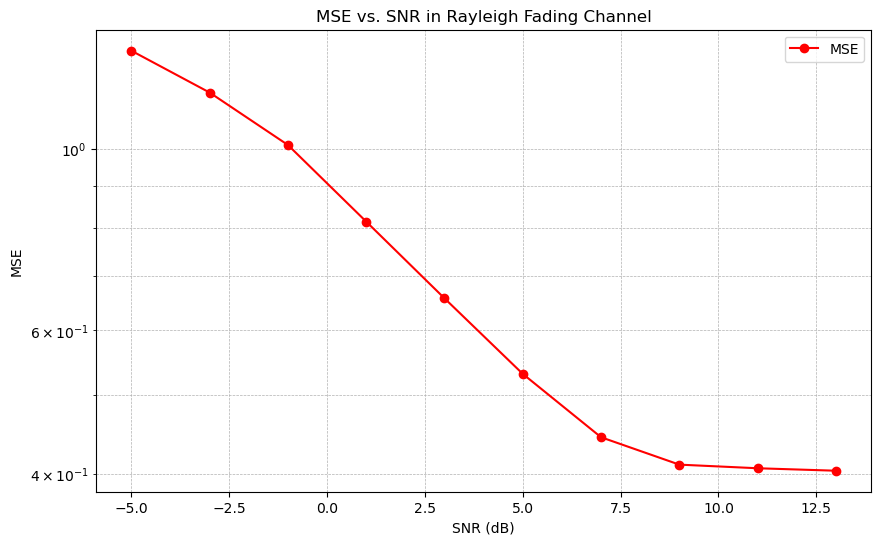

In [35]:
# Plot MSE vs. SNR
plt.figure(figsize=(10, 6))
plt.semilogy(snr_db_range, mse_values, marker='o', linestyle='-', color='r', label='MSE')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('SNR (dB)')
plt.ylabel('MSE')
plt.title('MSE vs. SNR in Rayleigh Fading Channel')
plt.legend()
plt.show()

In [36]:
# Doppler frequency range from 10 Hz to 300 Hz
doppler_freq_range = np.arange(10, 310, 20)
ber_vs_doppler = []
mse_vs_doppler = []

In [37]:
# Loop over each Doppler frequency
for fd in doppler_freq_range:
    Tc = 1 / (10 * fd)  # Update coherence time based on Doppler frequency
    packet_size = math.floor(Fs * Tc)  # Update packet size

    header_error = np.zeros(M)
    header_wrong_count = np.zeros(M)
    num = np.zeros(M)
    header_bit_count = np.zeros(M)
    cleaned_results = np.zeros((M, N))

    # Generate Rayleigh fading channel values for new Doppler frequency
    channel_values = np.array([generate_rayleigh_envelope(N, velocity, Fc) for _ in range(M)])

    # Loop over each packet
    for packet_start in range(0, len(signal), packet_size):
        packet_end = min(packet_start + packet_size, len(signal))
        current_signal = signal[packet_start:packet_end]
        current_channel_values = channel_values[:, packet_start:packet_end]

        for i in range(M):
            scaled = current_signal * current_channel_values[i]
            average_signal_power = np.mean(scaled ** 2)
            var_noise = average_signal_power * noise_level
            noise = np.random.normal(0, np.sqrt(var_noise), current_signal.shape)
            noisy = scaled + noise
            noisy_dig = digitize(noisy)

            # Perform LS separation
            header_start = int(packet_size / 2 - header_packet_size / 2)
            header_end = header_start + header_packet_size
            coeff, residuals, rank, s = lstsq(
                current_signal[header_start:header_end].reshape(-1, 1),
                noisy_dig[header_start:header_end]
            )
            cleaned_temp = noisy_dig / coeff
            cleaned = digitize(cleaned_temp)

            # Calculate header MSE
            header_error[i] += np.sum((coeff - current_channel_values[i]) ** 2)
            header_wrong_count[i] += np.sum(
                current_signal[header_start:header_end] != 
                cleaned[header_start:header_end]
            )
            num[i] += len(current_signal[header_start:header_end])
            header_bit_count[i] += len(current_channel_values[i])

            cleaned_results[i][packet_start:packet_end] = cleaned

    # Calculate BER and MSE for each Doppler frequency
    ber = np.mean([np.sum(np.abs(signal - cleaned_results[i])) for i in range(M)]) / N
    mse = np.mean(header_error / header_bit_count)
    ber_vs_doppler.append(ber)
    mse_vs_doppler.append(mse)


C:\Users\vigne\AppData\Local\Temp\ipykernel_11476\3107460744.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeff, residuals, rank, s = lstsq(
C:\Users\vigne\AppData\Local\Temp\ipykernel_11476\3107460744.py:36: RuntimeWarning: divide by zero encountered in divide
  cleaned_temp = noisy_dig / coeff


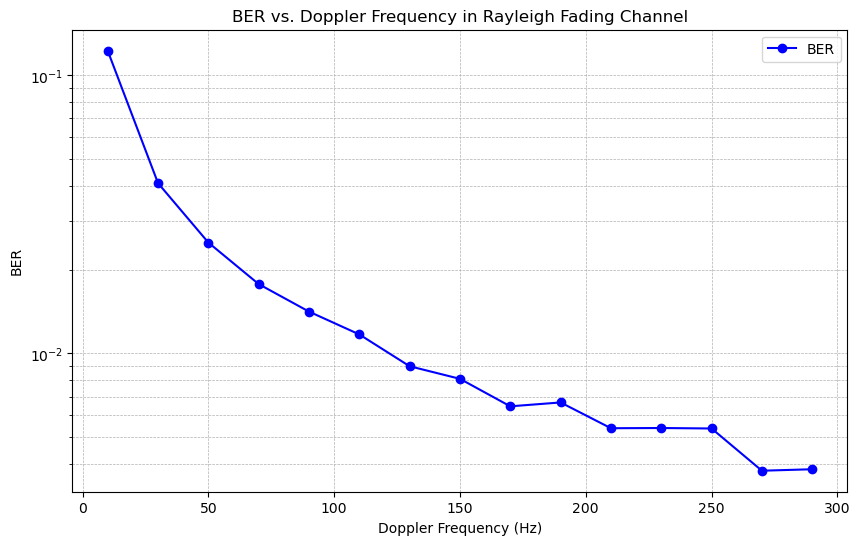

In [38]:
# Plot BER vs. Doppler Frequency
plt.figure(figsize=(10, 6))
plt.semilogy(doppler_freq_range, ber_vs_doppler, marker='o', linestyle='-', color='b', label='BER')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Doppler Frequency (Hz)')
plt.ylabel('BER')
plt.title('BER vs. Doppler Frequency in Rayleigh Fading Channel')
plt.legend()
plt.show()


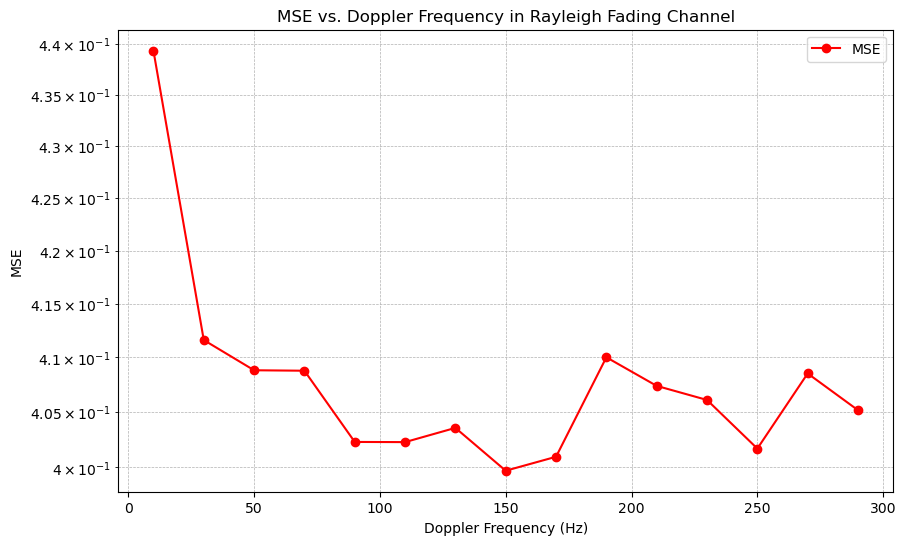

In [39]:
# Plot MSE vs. Doppler Frequency
plt.figure(figsize=(10, 6))
plt.semilogy(doppler_freq_range, mse_vs_doppler, marker='o', linestyle='-', color='r', label='MSE')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Doppler Frequency (Hz)')
plt.ylabel('MSE')
plt.title('MSE vs. Doppler Frequency in Rayleigh Fading Channel')
plt.legend()
plt.show()